In [1]:
%load_ext autoreload
%autoreload 2

# Slicing Aided Hyper Inference

Slicing Aided Hyper Inference (SAHI): First, the original query image $I$ is sliced into $l$ number of $M \times N$ overlapping patches $P_1^I, P_2^I, ..., P_l^I$. Then, each patch
is resized while preserving the aspect ratio. After that, object detection forward pass is applied independently to each overlapping patch. An optional full-inference (FI) using the
original image can be applied to detect larger objects. 

Finally, the overlapping prediction results and, if used, FI results are merged back into to original size using NMS. During NMS, boxes having higher Intersection over Union (IoU) ratios than a predefined matching threshold $T_m$ are matched and for each match, detections having detection probability than lower than $T_d$ are removed.

## Import everything

In [2]:
import keras_cv

from sahi import SAHI_HOME
import PIL 
import matplotlib.pyplot as plt
import numpy as np

2025-03-16 09:09:07.507784: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 09:09:07.509115: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 09:09:07.537116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 09:09:07.537135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 09:09:07.537151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Using TensorFlow backend


## 1. Predict bouinding boxes with a pretrained model

### Load a pre-trained model

In [3]:

pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh"
)


2025-03-16 09:09:09.658573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-16 09:09:09.665577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/none/fuentes/sahi/.venv/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id

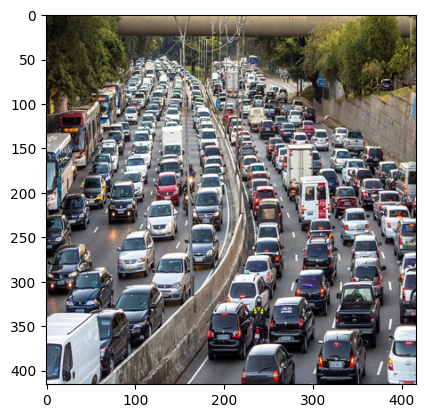

In [4]:


image_path = SAHI_HOME.parent /"notebook" /"images" / "test_1.jpeg"
with PIL.Image.open(image_path) as img:
    img = img.convert("RGB")
    img = img.resize((416, 416))
    

fig, ax = plt.subplots()
ax.imshow(img)

 

### Predict bounding boxes

In [56]:
batched_images = np.expand_dims(np.array(img), 0)

predicted_boxes = pretrained_model.predict(batched_images)

1/1 [==============================] - 0s 112ms/step


### Show prediction

In [65]:
def show_predictions(img, predicted_boxes):
    num_detections = predicted_boxes["num_detections"][0]
    boxes = predicted_boxes["boxes"][0]
    scores = predicted_boxes["confidence"][0]
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(num_detections):
        if scores[i] > 0.1:
            box = boxes[i]  
            class_name = "class"
            
            ax.add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color="red"))
            ax.text(box[0], box[1], f"{scores[i]:.2f}", color="red")
    return ax

<Axes: >

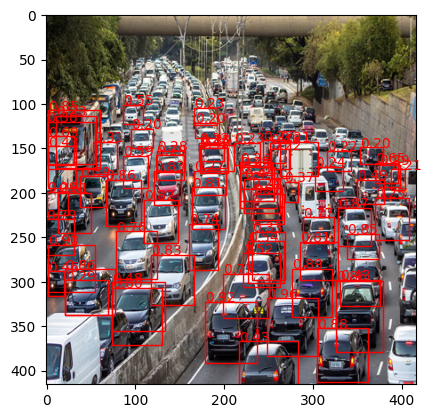

In [58]:
show_predictions(img, predicted_boxes)

## 2. Predict bouinding boxes with a pretrained model using SAHI

In [91]:
from sahi import SAHIConfig, sahi_predict
import logging 
logging.basicConfig(level=logging.DEBUG)
predictions = sahi_predict(
    pretrained_model,
    np.array(img),
    SAHIConfig(
        patch_size=(128, 128),
        overlapping_prportion=(0.5, 0.5),
        model_image_size=(416, 416),
    ),
)
predictions["boxes"] = np.expand_dims(predictions["boxes"] ,0)
predictions["confidence"] = np.expand_dims(predictions["confidence"] ,0)
predictions["classes"] = np.expand_dims(predictions["classes"] ,0)

DEBUG:sahi:Number of patches: 49


1/1 [==============================] - 5s 5s/step


In [92]:
def show_predictions(img, predicted_boxes):
    num_detections = predicted_boxes["boxes"].shape[1]
    print(num_detections)
    boxes = predicted_boxes["boxes"][0]
    scores = predicted_boxes["confidence"][0]
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(num_detections):
        if scores[i] > 0.2:
            box = boxes[i]  
            class_name = "class"
            
            ax.add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color="red"))
            ax.text(box[0], box[1], f"{scores[i]:.2f}", color="red")
    return ax

4900


<Axes: >

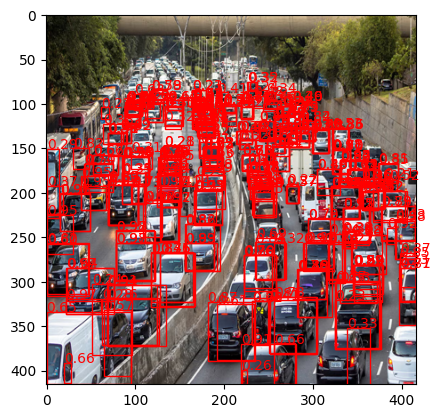

In [93]:

show_predictions(img, predictions)